In [2]:
import pprint

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pymongo import MongoClient

from sklearn.metrics import mean_absolute_error as mae
from sklearn.linear_model import LinearRegression

In [3]:
pp = pprint.PrettyPrinter(indent=2)

In [4]:
client = MongoClient(host="localhost", port=27017)

In [5]:
pp.pprint(list(client.list_databases()))

[ {'empty': False, 'name': 'admin', 'sizeOnDisk': 40960},
  {'empty': False, 'name': 'air-quality', 'sizeOnDisk': 82329600},
  {'empty': False, 'name': 'config', 'sizeOnDisk': 61440},
  {'empty': False, 'name': 'local', 'sizeOnDisk': 122880}]


In [6]:
database = client["air-quality"]

In [8]:
pp.pprint(list(database.list_collections()))

[ { 'idIndex': {'key': {'_id': 1}, 'name': '_id_', 'v': 2},
    'info': { 'readOnly': False,
              'uuid': Binary(b'&\x0cHJ\xfa\xf0H\x86\xb7\xddjx\r\xaa\xd1:', 4)},
    'name': 'india',
    'options': {},
    'type': 'collection'},
  { 'idIndex': {'key': {'_id': 1}, 'name': '_id_', 'v': 2},
    'info': { 'readOnly': False,
              'uuid': Binary(b'\xdf{\xaf\xf1(}E\x13\xb4\x05e\xc5\xfb\xae\xa6\xcd', 4)},
    'name': 'india-aq',
    'options': {},
    'type': 'collection'}]


In [9]:
collection = database["india"]

In [11]:
pp.pprint(collection.find_one())

{ 'AQI': '',
  'AQI_Bucket': '',
  'Benzene': '0',
  'CO': '1',
  'City': 'Ahmedabad',
  'Datetime': '1/1/2015 1:00',
  'NH3': '',
  'NO': '1',
  'NO2': '40.01',
  'NOx': '36.37',
  'O3': '',
  'PM10': '',
  'PM2': '',
  'SO2': '122.07',
  'Toluene': '0',
  'Xylene': '0',
  '_id': ObjectId('67f54f743fc4bf1cdcc605cf')}


In [230]:
mumbai = list(collection.find({
    "City": "Mumbai"
}))

In [231]:
mumbai[:1]

[{'_id': ObjectId('67f54f953fc4bf1cdccd9b78'),
  'City': 'Mumbai',
  'Datetime': '1/1/2015 1:00',
  'PM2': '',
  'PM10': '',
  'NO': '',
  'NO2': '',
  'NOx': '24.38',
  'NH3': '',
  'CO': '0',
  'SO2': '',
  'O3': '',
  'Benzene': '0',
  'Toluene': '0',
  'Xylene': '0',
  'AQI': '',
  'AQI_Bucket': ''}]

In [12]:
def wrangle(collection):
    
    results = list(collection.find({
        "City": "Mumbai"
    }, projection = {
        "Datetime": 1, "PM2":1, "_id": 0
    }))
    
    df = pd.DataFrame(results).set_index("Datetime")
    
    # Filter to only data from 2020
    df.index = pd.to_datetime(df.index)
    df = df[~df.index.year.isin(range(2015, 2020))]
    
    # Filter to Mumbai tz
    df.index = df.index.tz_localize("UTC").tz_convert("Asia/Kolkata")
    
    # Convert PM2 to floating point number
    df["PM2"] = df["PM2"].astype(float)
    
    # Remove outliers
    df = df[df["PM2"] < 140]
    
    # Create a lag feature
    df["PM2.L1"] = df["PM2"].shift(1)
    
    # Drop all null values
    df.dropna(inplace=True)
    
    return df

In [13]:
# Create dataframe
df = wrangle(collection)

In [14]:
#get the first five values of the dataframe
df.head()

,PM2,PM2.L1
Datetime,,
2020-01-01 06:30:00+05:30,88.78,80.90
2020-01-01 07:30:00+05:30,117.02,88.78
2020-01-01 08:30:00+05:30,127.49,117.02
2020-01-01 09:30:00+05:30,131.77,127.49
2020-01-01 10:30:00+05:30,133.52,131.77


In [15]:
# The number of rows and columns of df
df.shape

(2897, 2)

In [16]:
# general information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2897 entries, 2020-01-01 06:30:00+05:30 to 2020-05-01 05:30:00+05:30
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM2     2897 non-null   float64
 1   PM2.L1  2897 non-null   float64
dtypes: float64(2)
memory usage: 67.9 KB


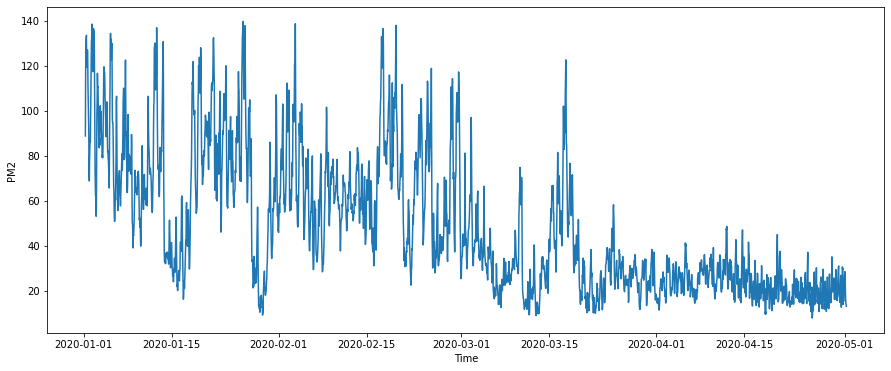

In [17]:
#Plot a time series graph (1 hour)
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot( df.index, "PM2" , data=df)
plt.xlabel("Time")
plt.ylabel("PM2")
plt.show()

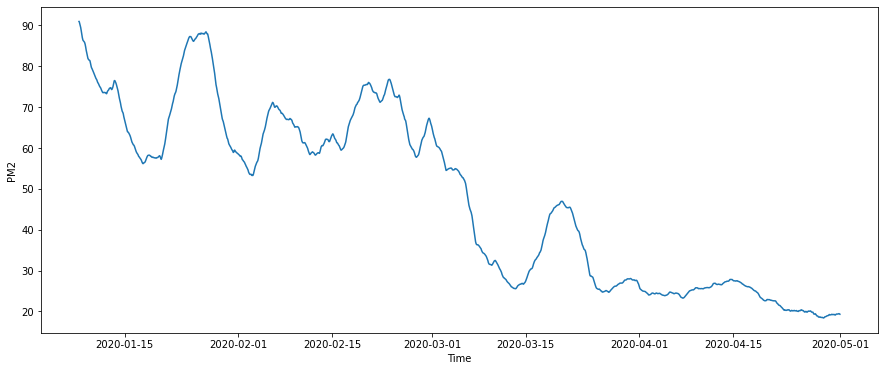

In [18]:
# A time series graph (1W) for better visualization
week = df["PM2"].rolling(168).mean()
plt.subplots(figsize=(15, 6))
plt.plot(week)
plt.xlabel("Time")
plt.ylabel("PM2")
plt.show()

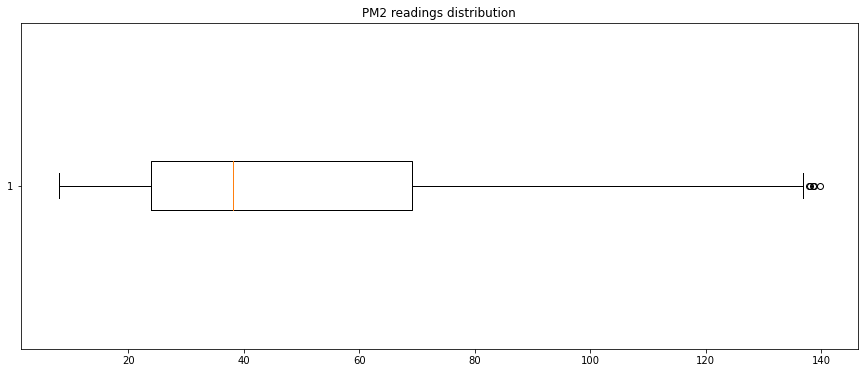

In [20]:
# Check PM2 distribution

plt.subplots(figsize=(15, 6))
plt.boxplot(df["PM2"], vert=False)
plt.title("PM2 readings distribution")
plt.show()

In [21]:
df.head()

,PM2,PM2.L1
Datetime,,
2020-01-01 06:30:00+05:30,88.78,80.90
2020-01-01 07:30:00+05:30,117.02,88.78
2020-01-01 08:30:00+05:30,127.49,117.02
2020-01-01 09:30:00+05:30,131.77,127.49
2020-01-01 10:30:00+05:30,133.52,131.77


In [22]:
df["PM2"].corr(df["PM2.L1"])

0.974436139721901

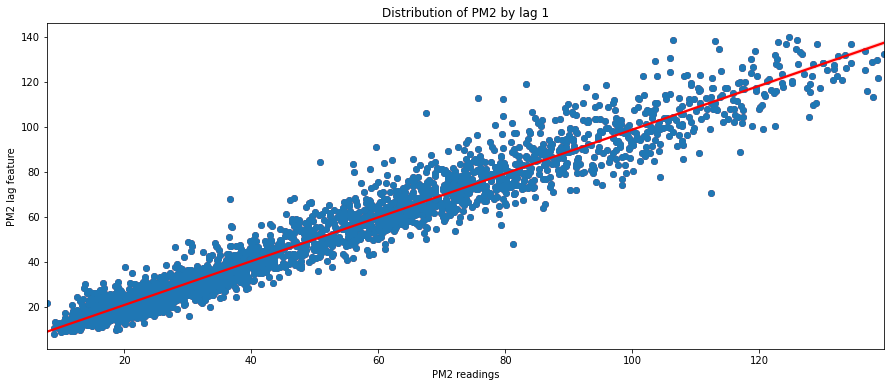

In [23]:
#Check corelation between PM2 and the lag feature
plt.subplots(figsize=(15, 6))
sns.regplot(x = "PM2", y = "PM2.L1", data=df, color="red")
plt.scatter("PM2", "PM2.L1", data=df)
plt.xlabel("PM2 readings")
plt.ylabel("PM2 lag feature")
plt.title("Distribution of PM2 by lag 1")
plt.show()

In [24]:
# target/feature split
target = "PM2"
X = df.drop(columns=target)
y = df[target]

In [25]:
# train test split
cutoff = int(len(X) * 0.8)
X_train, y_train = X[:cutoff], y[:cutoff]
X_test, y_test = X[cutoff:], y[cutoff:]

In [27]:
# calculate baseline mae
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mae(y_train, y_pred_baseline)
baseline_mae

25.17927308782788

In [28]:
# train model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [29]:
# test model on train data
y_pred_train = model.predict(X_train)
y_pred_train[:5]

array([ 80.13102417,  87.7851797 , 115.21580815, 125.38573308,
       129.54306628])

In [30]:
# Calculate mean absolute error on train data
training_mae = mae(y_train, y_pred_train)
training_mae

5.103044019552854

In [31]:
# test model on test data
y_pred_test = model.predict(X_test)
y_pred_test[:5]

array([17.29506969, 16.2363096 , 15.5952255 , 16.58599183, 20.51020355])

In [32]:
# Calculate mean absolute error on test data
test_mae = mae(y_test, y_pred_test)
test_mae

3.516527657954878

In [36]:
pred_dict = {"y_test": y_test, 
            "y_pred_test": y_pred_test}
df_test = pd.DataFrame(pred_dict, index=y_test.index)

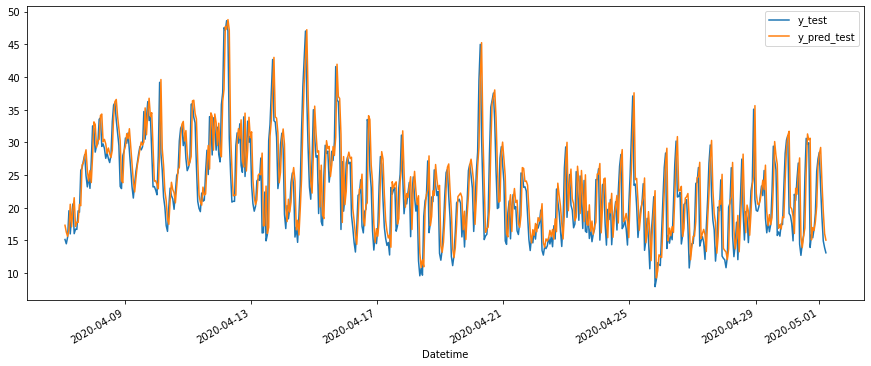

In [40]:
fig,ax = plt.subplots(figsize=(15,6))
df_test.plot(ax=ax);